#                      STOCK MARKET PREDICTION

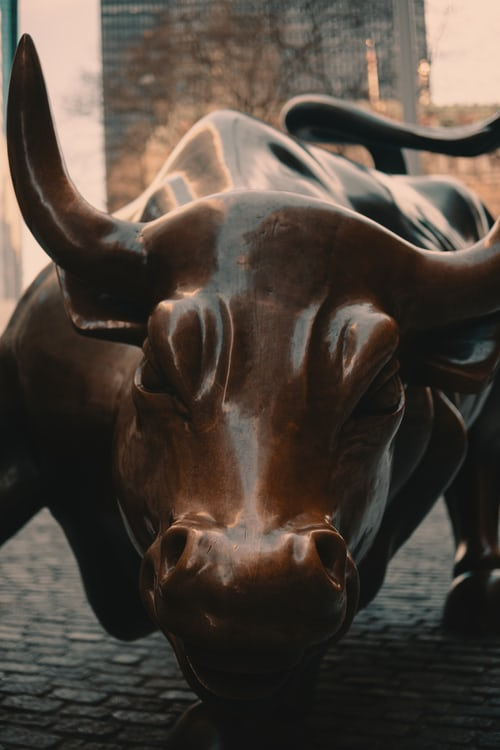

### Predicting stock prices using the power of Machine Learning has been a rapidly sought after research topics.
### Owing to the very nature of Stocks. The prediction depends on a **variety of factors**:
#### Market sentiments are one of such factors on which the price of stock largely depends.

### Market sentiments play a driving role in the pricing of the stock and the smart players are well aware of this boon in disguise. 

### In this notebook I have tried to model algorithms and hypertune their hyperparameters for predicting market sentiments which can then be used to price the stock in future with the maximum accuracy.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## getting our arsenal ready!!

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
%matplotlib notebook

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import nltk
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from collections import Counter 
from wordcloud import WordCloud
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

## let us load the dataset

In [ ]:
## loading the dataset
sentiment_dataset = pd.read_csv("../input/stockmarket-sentiment-dataset/stock_data.csv")

## lets look at the data available

In [ ]:
sentiment_dataset.head(5)

#### so the first column contains the news and second has the sentiment


In [ ]:
sentiment_dataset.info()

In [ ]:
## percentage of positive and negative sentiments
(sentiment_dataset["Sentiment"].value_counts()/len(sentiment_dataset)) * 100

#### Ohho!! we have a fair large number of data points 5791 in total
#### with a 7:4 taget values (which is good)

In [ ]:
## Plot the Sentiment value count 
sns.countplot(x=sentiment_dataset["Sentiment"] )

#### the above plot shows fair number of news inclined in positive but the imbalance in not that much

## Checking for stopwords

In [ ]:
stop_words=set(stopwords.words("english"))

In [ ]:
word_list = list()
for i in range(len(sentiment_dataset)):
    words = sentiment_dataset.Text[i].split()
    for j in words:
        word_list.append(j)

In [ ]:
wordCounter = Counter(word_list)
countedWordDict = dict(wordCounter)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)
sortedWordDict[0:20]

#### these are the stop words present in the news text

In [ ]:
stop_word_Cloud = set(stopwords.words("english"))
wordcloud = WordCloud(stopwords=stop_word_Cloud,max_words=2000,background_color="black",min_font_size=5).generate_from_frequencies(countedWordDict)
plt.figure(figsize=[10,5])
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

## Data Preprocessing

#### Replacing the negative one with zero so our model can predict well

In [ ]:
sentiment_dataset["Sentiment"] = sentiment_dataset["Sentiment"].replace(-1,0)

#### NLP Processing

In [ ]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

#### cleaning the text

In [ ]:
text_reviews = list()
for i in range(len(sentiment_dataset)):
    text = re.sub('[^a-zA-Z]'," ",sentiment_dataset['Text'][i])
    text = text.lower()
    text = word_tokenize(text,language="english")
    text = [lemma.lemmatize(word) for word in text if(word) not in stopwordSet]
    text = " ".join(text)
    text_reviews.append(text)

#### creating the Bag of Word model

In [ ]:
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(text_reviews).toarray()
Y= sentiment_dataset['Sentiment']

## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.25, random_state = 1)

## Modelling

### 1. Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)

In [ ]:
print("logistic regression\n")
print("confusion matrix:\n {}".format(confusion_matrix(y_test, Y_pred)))
print("\n\naccuracy: {}".format(accuracy_score(y_test, Y_pred)))

#### the model gave an accuracy of 76.79%. Let's see if it can be increased by hypertuning

## hyperparameter tuning for logistic regression

In [ ]:
logreg = LogisticRegression()

#listing hyperparameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)


# summarize results
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


### 2. Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)

In [ ]:
print("Random Forest\n")
print("confusion matrix:\n {}".format(confusion_matrix(y_test, Y_pred)))
print("\n\naccuracy: {}".format(accuracy_score(y_test, Y_pred)))

## hyperparameter tuning for random forest classifier

In [ ]:
random_forest = RandomForestClassifier()

#listing hyperparameters
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

# defining grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=random_forest, param_grid=grid, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)


# summarizing results
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


dataset link: [stockmarket-sentiment-dataset](https://www.kaggle.com/yash612/stockmarket-sentiment-dataset)

ensemble methods can increase the accuracy by a notable amount. 